In [2]:
#installs and imports

%pip install ultralytics 
%pip install scikit-learn
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt
from ultralytics import YOLO
from IPython.display import display, Image
from IPython import display
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score


display.clear_output()

In [13]:
#uncomment the following 7 code lines to download the Roboflow dataset

# %pip install roboflow
# from roboflow import Roboflow
# rf = Roboflow(api_key="_") # must write your own account api key from the roboflow website
# project = rf.workspace("connectfour").project("connect4-bmekp")
# version = project.version(3)
# dataset = version.download("yolov8")
# display.clear_output()

# might need to modify paths in data.yaml like this:
# test: ../test/images
# train: ../train/images
# val: ../valid/images

In [ ]:
#uncomment to train the yolov8 model

# !yolo task=segment mode=train model=yolov8n-seg.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 #train
# !yolo task=segment mode=val model=/content/runs/segment/train2/weights/best.pt data={dataset.location}/data.yaml #validation
# !yolo task=segment mode=predict model=runs/segment/train2/weights/best.pt conf=0.7 source="Connect4-3/test/images" save = False

#another way of writing the testing, to save the results

# model = YOLO('runs/segment/train2/weights/best.pt')  
# results = model("Connect4-3/test/images")

In [14]:
#function to split the cutout image of the board into 42 pieces, of size 100x 100 px
def make_squares(img):

    #inverse colors to normal
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 

    #given an np array, make it image type
    img = Image.fromarray(img)

    # the directory to save the smaller images. After saving them there I manually sort them into the 3 adnotated photos folders
    output_dir = "pieces/test"
    os.makedirs(output_dir, exist_ok=True)

    # the size of each square image
    tile_width = 100
    tile_height = 100

    # the number of rows and columns
    rows = 6
    cols = 7

    # loop through the board image and save each 100x100 px square
    for row in range(rows):
        for col in range(cols):
            left = col * tile_width
            upper = row * tile_height
            right = left + tile_width
            lower = upper + tile_height
            
            # crop the image
            cropped_img = img.crop((left, upper, right, lower))
            
            # cave the cropped image
            cropped_img.save(os.path.join(output_dir, f"tile_{row}_{col}.jpg"))

    print(f"All tiles have been saved in the '{output_dir}' directory.")


In [15]:
#ml model to predict pieces (mobileNet)

#function to train the model
def train_model(model, train_loader, criterion, optimizer,num_epochs,device):
   
    # set model to training mode
    model.train() 

    for epoch in range(num_epochs):
        #reset loss for the epoch
        running_loss = 0.0

        for inputs, labels in train_loader:

            # move data to the GPU
            inputs, labels = inputs.to(device), labels.to(device) 
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass  
            outputs = model(inputs) 
            # Compute loss 
            loss = criterion(outputs, labels) 
            # Backward pass 
            loss.backward() 
            # Optimize
            optimizer.step()  

            #add to loss
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    print("Training complete")


#function to validate model
def validate_model(model, val_loader, criterion,device):

    # set model to evaluation mode and reset values
    model.eval()  
    running_loss = 0.0
    correct = 0
    total = 0

    #we don't need to calculate gradients for eval
    with torch.no_grad():

        for inputs, labels in val_loader:

            # Move data to the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            #saves the predicted label with the maximum score 
            _, predicted = torch.max(outputs, 1)
            #keep track of the total numbers of labels in the val set, by adding the nr. of samples in current batch to the total
            total += labels.size(0)
            #count the nr. of correct predictions in this batch, transform into scalar and add to correct total
            correct += (predicted == labels).sum().item()
    #precentage of correct predictions made 
    accuracy = 100 * correct / total
    print(f'Validation Loss: {running_loss/len(val_loader)}, Accuracy: {accuracy}%')


def train_and_validate():

    # define transforms
    transform = transforms.Compose([
        # Resize images to 224x224 as required by MobileNet
        transforms.Resize((224, 224)), 
        # convert images to PyTorch tensors 
        transforms.ToTensor(),    
        # Normalize with ImageNet means and stds      
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])

    # set the device to GPU 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # load data using ImageFolder
    dataset = datasets.ImageFolder(root='pieces/organized', transform=transform)

    #size for training, 80%
    train_size = int(0.8 * len(dataset))
    # remaining for validation
    val_size = len(dataset) - train_size 
    # split dataset with random values 
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # create DataLoader for validation and train set
    val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)

    train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

    # pre-trained MobileNet model
    model = models.mobilenet_v2(weights=True)

    # modify the classifier
    model.classifier = nn.Sequential(
        #dropout regularization with 50% chance of dropout
        nn.Dropout(p=0.5),
        # Increase dimensionality to match the Conv2d input
        nn.Linear(model.classifier[1].in_features, 1280), 
        # Rectified Linear Unit activation function, which introduces non-linearity to the model
        nn.ReLU(),
        # Reshape to match Conv2d inputto a 4-dimensional tensor with dimensions (batch_size, 40, 32, 1)
        nn.Unflatten(1, (40, 32, 1)),  
        # 2-dimensional convolutional layer with 40 input channels, 128 filters size 3x3, padding 1 
        nn.Conv2d(in_channels=40, out_channels=128, kernel_size=3, padding=1),
        #anothe ReLU
        nn.ReLU(),
        # adaptive average pooling to reduce dimensionality
        nn.AdaptiveAvgPool2d((1, 1)),  
        #flattens the input tensor into a 1-dimensional tensor
        nn.Flatten(),
        # Final classification layer, gives the final 3 lclasses
        nn.Linear(128, 3)  
    )

    # Move the model to the device
    model.to(device)

    #for multi class classification
    criterion = nn.CrossEntropyLoss()
    #Adam optimizer for efficiency
    optimizer=optim.Adam(model.parameters(), lr=0.00005)

    train_model(model, train_loader, criterion, optimizer, 50, device)

    validate_model(model, val_loader, criterion, device)

    # uncomment to save the model's state dictionary
    # torch.save(model.state_dict(), 'my_model.pth')

In [12]:
#Predict the class of a single image using the trained model.
def predict_image(image_path, model, device,transform):
    
    image = Image.open(image_path)
    image = transform(image)
    # Add batch dimension
    image = image.unsqueeze(0)  
    # Move the image to GPU if available
    image = image.to(device)   
    
    # No need to compute gradients
    with torch.no_grad():  
        # Perform inference
        outputs = model(image)  
        # Get the predicted class index
        _, predicted = torch.max(outputs, 1) 
    
    return predicted.item()  # Return the predicted class index


#evaluate the model on a test set organized in subfolders
def test_model(test_folder, model, device, transform):

    true_labels =[]
    predicted_labels =[]

    #iterate over each label subfolder
    for label in ['0','1','2']:

        label_folder = os.path.join(test_folder, label)

        if not os.path.isdir(label_folder):
            print(f"Folder {label_folder} does not exist.")
            continue

        for filename in os.listdir(label_folder):
            
            if filename.lower().endswith(('.png','.jpg','.jpeg')):
                image_path = os.path.join(label_folder, filename)
                #true label derived from folder name
                true_label = int(label)
                true_labels.append(true_label)
                #predict the class for the img
                predicted_class = predict_image(image_path,model,device,transform)
                predicted_labels.append(predicted_class)

    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'Test Accuracy: {accuracy:}')


def test():

    # Define transforms
    transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize images to 224x224 as required by MobileNet
            transforms.ToTensor(),          # Convert images to PyTorch tensors
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet means and stds
        ])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define the model architecture
    model = models.mobilenet_v2(pretrained=False)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(model.classifier[1].in_features, 1280),  
        nn.ReLU(),
        nn.Unflatten(1, (40, 32, 1)), 
        nn.Conv2d(in_channels=40, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)),  
        nn.Flatten(),
        nn.Linear(128, 3) 
    )

    model.load_state_dict(torch.load('yolov8n-seg.pt'))
    model.to(device) 
    # Set the model to evaluation mode
    model.eval()      

    # the path to the folder containing images
    folder_path = 'pieces/test'

    # Predict the classes for all images in the folder
    test_model(folder_path, model, device, transform)

In [75]:
#bfs to find closest edge of the border from the start point
def Connect4BFS(matrix, start): 

    (x, y)= start
    #if start is on the border
    if matrix[x][y] > 0:
        return [y, x]

    qe = [(x, y)]
    visited = set()
    visited.add((x, y))

    height = 640
    length = 640

    #directions
    dx=[1, 0, -1, 0]
    dy=[0, 1, 0, -1]

    while qe:
        x, y = qe.pop(0)

        # Explore the neighboring nodes
        for k in range(4):
            nx = x+dx[k]
            ny = y+dy[k]
            if 0 <= nx < length and 0 <= ny < height:
                if (nx, ny) not in visited:
                    visited.add((nx, ny))
                    qe.append((nx, ny))
                if matrix[nx][ny] ==1:
                    return [ny, nx]                


#stretch image so that the border of the playable board fits in a 700x600 rectangle        
def Connect4GetBoard(image,matrix):

    ul= Connect4BFS(matrix, (0,0)) #left up
    ur= Connect4BFS(matrix, (0,639)) #right up
    dr= Connect4BFS(matrix, (639,639)) #right down
    dl= Connect4BFS(matrix, (639,0)) #left down 

    image = cv.imread(image)
    result = image.copy()

    #margin of error
    margin = 4
    ul[0] -= margin
    ul[1] -= margin
    ur[0] += margin
    ur[1] -= margin
    dr[0] += margin
    dr[1] += margin
    dl[0] -= margin
    dl[1] += margin

    #uncomment to see circled where the detected edges are
    # cv.circle(result, ul, 10, (255,0,0))
    # cv.circle(result, ur, 10, (255,0,0))
    # cv.circle(result, dr, 10, (255,0,0))
    # cv.circle(result, dl, 10, (255,0,0))

    # plt.imshow(result)
    # plt.show()
    
    #source coordinates
    src = np.array([ul, ur, dr, dl], dtype="float32")
    #destination coordinates
    dst = np.array([[0, 0], [0, 700], [600, 700],[600, 0] ], dtype="float32")
    #get transformation matrix
    m = cv.getPerspectiveTransform(src, dst)
    #wrap image using matrix
    result = cv.warpPerspective(image, m, (600, 700))
    #must rotate and flip
    result = cv.rotate(result, cv.ROTATE_90_CLOCKWISE)
    result = cv.flip(result, 1)

    return result


#makes a matrix (640x640) of points with mask contour
def Connect4MakeGrid(mask): 
  
  #coordinates of the points of first mask found
  mask = mask.xy[0]
  
  grid = np.zeros((640,640))
  for pair in mask:
    grid [int(pair[1])] [int(pair[0])] = 1

#   plt.imshow(grid)
#   plt.show()
  
  return grid


#detect piece with hsv masks
def DetectPiece(region):

    # Convert region to HSV for better color segmentation
    hsv = cv.cvtColor(region, cv.COLOR_BGR2HSV)
    
    # Define color ranges for red and yellow
    red_lower1 = np.array([0, 120, 70])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([170, 120, 70])
    red_upper2 = np.array([180, 255, 255])
    
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    
    # Create masks for red and yellow
    mask_red1 = cv.inRange(hsv, red_lower1, red_upper1)
    mask_red2 = cv.inRange(hsv, red_lower2, red_upper2)
    mask_red = cv.bitwise_or(mask_red1, mask_red2)
    mask_yellow = cv.inRange(hsv, yellow_lower, yellow_upper)
    
    # Check for the presence of each color in the region
    red_presence = np.sum(mask_red > 0)
    yellow_presence = np.sum(mask_yellow > 0)
    
    # Determine if a piece is present and its color
    if red_presence > yellow_presence and red_presence > 1200:  # threshold for minimum presence
        return 1 #red
    elif yellow_presence > red_presence and yellow_presence > 1000:
        return 2 #yellow
    else:
        return 0 #empty
    

#detect piece with mobilenetv2
def get_state_with_Ml(board,model,transform,device):

    #empty board
    game = np.zeros((6, 7)).astype(int)

    # we have a 700x600 image that we want to split into 100x100 squares, which we will then 
    # run some computer vision techniques to figure out the piece present
    for row in range (6):
        for col in range(7):
            #slice the piece region
            region = board[row*100:(row+1)*100, col*100:(col+1)*100]
            
            # Convert the region to a PIL image and apply transformations
            region_pil = Image.fromarray(cv.cvtColor(region, cv.COLOR_BGR2RGB))
            region_tensor = transform(region_pil).unsqueeze(0)  # Add batch dimension
            region_tensor = region_tensor.to(device)  # Move to GPU if available
            
            # Perform inference
            with torch.no_grad():
                outputs = model(region_tensor)
                _, predicted = torch.max(outputs, 1)  # Get the predicted class index
            
            game[row][col] = predicted.item()  # Store the prediction in the game board matrix

    for line in game:
        print(*line)
    
    state = cv.cvtColor(board, cv.COLOR_BGR2RGB)
    plt.imshow(state)
    plt.show()

    return game


#detect game state
def GetState(board):

    game = np.zeros((6, 7)).astype(int)
    # we have a 700x600 image that we want to split into 100x100 squares, which we will then 
    # run some computer vision techniques to figure out the piece present
    for row in range (6):
        for col in range(7):
            region = board[row*100:(row+1)*100, col*100:(col+1)*100]
            game[row][col] = DetectPiece(region)
    print("the detected board")
    for line in game:
        print(*line)
    
    state = cv.cvtColor(board, cv.COLOR_BGR2RGB)
    plt.imshow(state)

    return game


#run code
def Connect4Run(image):
  
  yolo_model = YOLO(model="best.pt") #load trained model, must change path
  # results = model('/content/Connect4-3/test/images') #test model and save results
  result = yolo_model(source=image,  save=False)
  if result[0].masks is None:
      print("No masks detected")
      return
  # Get masks from the results from the segmentation model
  mask = result[0].masks
  grid = Connect4MakeGrid(mask)
  board = Connect4GetBoard(image,grid)

  # Set the device to GPU 
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = models.mobilenet_v2(weights=False)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.classifier[1].in_features, 1280),  # Increase dimensionality to match the Conv2d input
    nn.ReLU(),
    nn.Unflatten(1, (40, 32, 1)),  # Reshape to match Conv2d input
    nn.Conv2d(in_channels=40, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),  # Pooling to reduce dimensionality
    nn.Flatten(),
    nn.Linear(128, 3)  # Final classification layer
  )

  model.load_state_dict(torch.load('dropout_ReLU.pth'))
  model.to(device)  # Move the model to the GPU if available
  model.eval()      # Set the model to evaluation mode
  

# uncomment to save images of the pieces of the board 
#   make_squares(board)

# uncomment for old piece detection, with hsv masks
# game = GetState(board)

        # Define transforms
  transform = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize images to 224x224 as required by MobileNet
      transforms.ToTensor(),          # Convert images to PyTorch tensors
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet means and stds
    ])
  
  game = get_state_with_Ml(board, model,transform,device)


image 1/1 /home/julie/Github/ConnectFour/backend/Connect4-3/train/images/20240325_135319_jpg.rf.223ef3632a154a40c0296b4eaf04e464.jpg: 640x640 1 board, 68.7ms
Speed: 3.6ms preprocess, 68.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


/home/julie/Github/ConnectFour/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


2 1 1 1 1 1 2
2 1 1 1 1 1 2
2 1 1 2 1 1 2
2 1 1 1 1 1 2
2 2 2 1 2 2 2
2 2 2 2 2 2 2


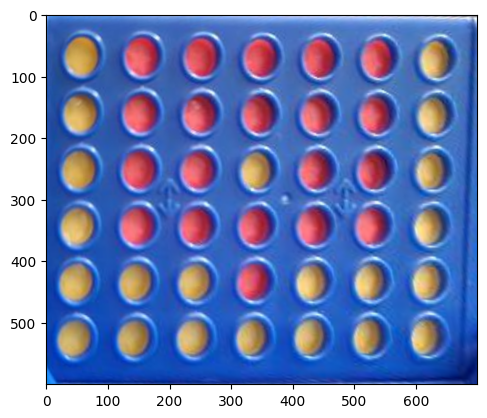

In [102]:
# path = "Connect4-3/valid/images/20240325_134951_jpg.rf.9f3f54fa68f52a825839fcc366fac18e.jpg"
# path = "Connect4-3/test/images/WIN_20240325_19_00_55_Pro_jpg.rf.8784b14a9326fe061c898b28171296e9.jpg"
# path = 'Connect4-3/train/images/20240325_135319_jpg.rf.223ef3632a154a40c0296b4eaf04e464.jpg' 
path = 'Connect4-3/train/images/20240325_135319_jpg.rf.223ef3632a154a40c0296b4eaf04e464.jpg'
Connect4Run(path)

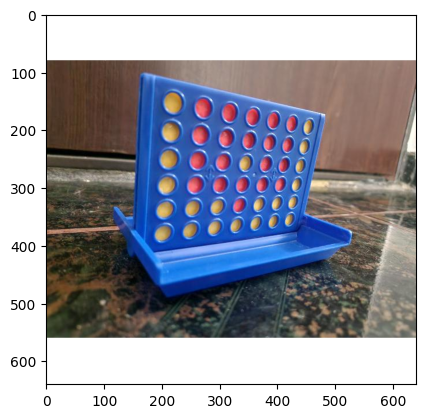

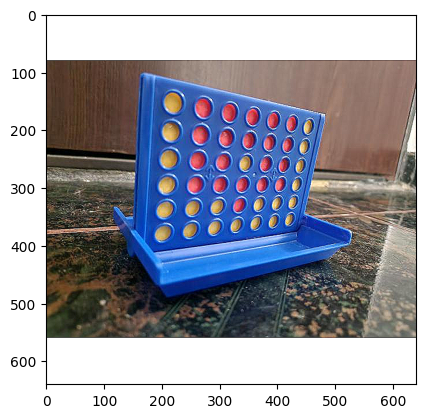

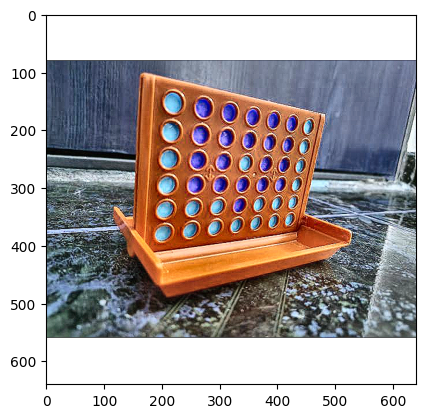

True

In [101]:
# path = "Connect4-3/test/images/WIN_20240325_19_00_55_Pro_jpg.rf.8784b14a9326fe061c898b28171296e9.jpg"
# path =  "Connect4-3/train/images/20240325_135727_jpg.rf.5f60c8bd91e9d5ab523c1a003cd1aa6a.jpg"
path = 'Connect4-3/train/images/20240325_135319_jpg.rf.223ef3632a154a40c0296b4eaf04e464.jpg' 
# path = "Connect4-3/train/images/20240325_133556_jpg.rf.a4eaf7d5661c958520f3dd903f78c756.jpg"
# path = "Connect4-3/train/images/c_jpg.rf.0caf38e73fea89a582b5781d2dd90e0f.jpg"
# path = "Connect4-3/train/images/WIN_20240325_18_59_03_Pro_jpg.rf.53e603a972b8df78a0a5ec06012f4ef0.jpg"

def enhance_image_fail(path):
    photo = cv.imread(path)
    photo = cv.cvtColor(photo, cv.COLOR_BGR2RGB)

    # Sharpening kernel
    kernel = np.array([[0, -1, 0],
                    [-1, 5,-1],
                    [0, -1, 0]])

    # Apply the kernel to the RGB image
    photo_sharp = cv.filter2D(photo, -1, kernel)

    # Convert to LAB color space
    lab_image = cv.cvtColor(photo_sharp, cv.COLOR_BGR2LAB)
    # Apply CLAHE to the L channel
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab_image[:,:,0] = clahe.apply(lab_image[:,:,0])
    # Convert back to BGR color space
    final_image = cv.cvtColor(lab_image, cv.COLOR_LAB2RGB)


    plt.imshow(photo)
    plt.show()
    plt.imshow(photo_sharp)
    plt.show()
    plt.imshow(final_image)
    plt.show()

    cv.imwrite('test/final_image.jpg', final_image)
    cv.imwrite('test/sharp_image.jpg', cv.cvtColor(photo_sharp, cv.COLOR_BGR2RGB))